# Boosting and Stacking Exercises

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.

In [2]:
import pandas as pd
import numpy as np

file_path = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(file_path, sep=',', header=0)

The data has quite a few predictor columns.

In [3]:
data.shape

(10299, 562)

And they're all float values. The only non-float is the categories column, which is what's being predicted.

In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.

In [5]:
# Mask to select float columns
float_columns = (data.dtypes == np.float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )

True
True


In [6]:
(data.loc[:,float_columns].max()==1.0)

tBodyAcc-mean()-X                       True
tBodyAcc-mean()-Y                       True
tBodyAcc-mean()-Z                       True
tBodyAcc-std()-X                        True
tBodyAcc-std()-Y                        True
tBodyAcc-std()-Z                        True
tBodyAcc-mad()-X                        True
tBodyAcc-mad()-Y                        True
tBodyAcc-mad()-Z                        True
tBodyAcc-max()-X                        True
tBodyAcc-max()-Y                        True
tBodyAcc-max()-Z                        True
tBodyAcc-min()-X                        True
tBodyAcc-min()-Y                        True
tBodyAcc-min()-Z                        True
tBodyAcc-sma()                          True
tBodyAcc-energy()-X                     True
tBodyAcc-energy()-Y                     True
tBodyAcc-energy()-Z                     True
tBodyAcc-iqr()-X                        True
tBodyAcc-iqr()-Y                        True
tBodyAcc-iqr()-Z                        True
tBodyAcc-e

## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [6]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5], dtype=int64)

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [7]:
from sklearn.model_selection import train_test_split

feature_cols = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_cols],data['Activity'],
                                                   test_size=0.3, random_state=45)


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

## Question 3

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 3 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()
tree_list = [25,50,100,200,400]

for n_trees in tree_list:
    gbc = GradientBoostingClassifier(n_estimators=n_trees,
                               subsample=.5,
                               max_features=4,
                               random_state=45)
    
    gbc.fit(X_train, y_train)
    y_pred = gbc.predict(X_test)
    
    error = 1 - accuracy_score(y_test, y_pred)
    error_list.append(pd.Series({'n_trees':n_trees,'error':error}))
    
error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')
error_df

,error
n_trees,
25.0,0.066343
50.0,0.042071
100.0,0.024272
200.0,0.014887
400.0,0.009385


Now plot the result.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [11]:
#!pip install seaborn

(0, 440.00000000000006)

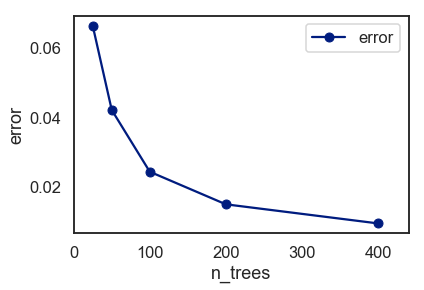

In [12]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = error_df.plot(marker='o')
ax.set(ylabel='error',xlabel='n_trees')
ax.set_xlim(0, max(error_df.index)*1.1)

## Question 4

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate':[0.1,0.01,0.001],
              'n_estimators':[200,400,500]}

GV_GBC = GridSearchCV(GradientBoostingClassifier(max_features=4,
                                                 subsample=.5,
                                                 random_state=45),
                     param_grid=param_grid,
                     scoring='accuracy',
                     n_jobs=-1)

GV_GBC.fit(X_train, y_train)

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_...      subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [200, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=45,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [15]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       0.98      0.98      0.98       526
           2       0.98      0.99      0.98       562
           3       1.00      1.00      1.00       501
           4       1.00      0.99      0.99       433
           5       0.99      1.00      0.99       472

   micro avg       0.99      0.99      0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.

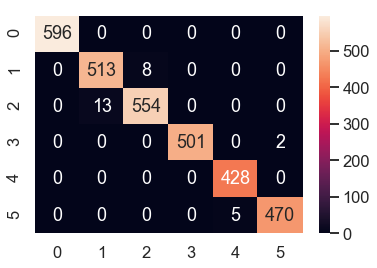

In [16]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 5

* Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid={'n_estimators':[100,200,300],
            'learning_rate':[0.1,0.01,0.001]}

GV_ABC = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_features=4)),
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The best model.

In [18]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=200, random_state=None)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic and now include class 0. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [19]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       605
           1       0.69      0.69      0.69       521
           2       0.74      0.75      0.74       559
           3       0.89      0.86      0.87       518
           4       0.87      0.87      0.87       430
           5       0.83      0.86      0.84       457

   micro avg       0.80      0.80      0.80      3090
   macro avg       0.80      0.80      0.80      3090
weighted avg       0.80      0.80      0.80      3090



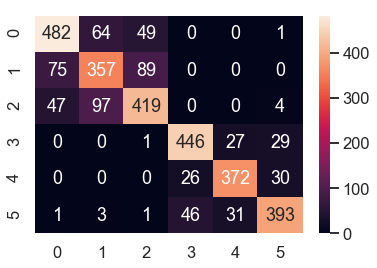

In [20]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 6

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [21]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to c

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Check the errors and confusion matrix for the logistic regression model.

In [22]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       0.95      0.95      0.95       521
           2       0.95      0.95      0.95       566
           3       1.00      1.00      1.00       502
           4       1.00      1.00      1.00       427
           5       1.00      0.99      1.00       478

   micro avg       0.98      0.98      0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



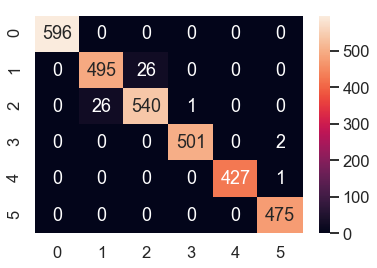

In [23]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [24]:
from sklearn.ensemble import VotingClassifier

estimators = [('LR_LR', LR_L2),('GV_GBC',GV_GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to c

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [25]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       0.97      0.98      0.97       521
           2       0.98      0.97      0.98       567
           3       1.00      1.00      1.00       503
           4       1.00      1.00      1.00       428
           5       1.00      1.00      1.00       475

   micro avg       0.99      0.99      0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



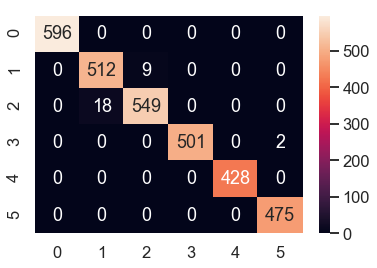

In [26]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 7
* Import the iris data and examine the features.
* We will be using all of them to predict species, but the species feature will need to be integer encoded.
* Download iris.csv from https://www.kaggle.com/uciml/iris/data/  and rename it as Iris_Data.csv

In [27]:
file_path = os.sep.join(data_path+['Iris_Data.csv'])
data = pd.read_csv(file_path, sep=',', header=0)

Convert the species feature to an integer. This is a quick way to do it using Pandas.

In [28]:
data['species'] = data['species'].replace(['Iris-versicolor', 'Iris-setosa','Iris-virginica'],[0,1,2]).astype(np.int)

## Question 8

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by species. If possible, preserve the indices of the split for question 11 below.
* Check the percent composition of each species level for both the train and test data sets.

In [29]:
# All data columns except for species
from sklearn.model_selection import StratifiedShuffleSplit
feature_cols = [x for x in data.columns if x!='species']

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=45)
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols],data['species']))

# create the datasets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'species']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'species']

Now check the percent composition of target class in the train and test iris_data sets.

In [30]:
y_test.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: species, dtype: float64

In [31]:
y_train.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: species, dtype: float64

## Question 9

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 9 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

trees = [25,50,100,200,400]
error_list = list()

for n_trees in trees:
    gbc = GradientBoostingClassifier(n_estimators=n_trees,
                                     max_features=4,
                                     subsample=.5,
                                     random_state=45)
    gbc.fit(X_train, y_train)
    y_pred = gbc.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    
    error_list.append(pd.Series({'n_trees':n_trees,'error':error}))
    
error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')
error_df

,error
n_trees,
25.0,0.066667
50.0,0.066667
100.0,0.066667
200.0,0.066667
400.0,0.066667


Now plot the result.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

[Text(0,0.5,'Error'), Text(0.5,0,'n_trees')]

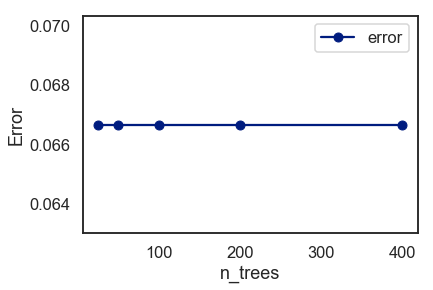

In [35]:
sns.set('talk','white','dark')

ax = error_df.plot(marker='o')
ax.set(ylabel='Error', xlabel='n_trees')

## Question 10

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 9. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate':[0.1,0.01,0.001, 0.0001,0.00001],
              'n_estimators':[20, 25, 50, 100, 200]}

gv_gbc = GridSearchCV(GradientBoostingClassifier(max_features=4,
                                                subsample=.5,
                                                random_state=45),
                     param_grid=param_grid,
                     scoring='accuracy',
                     n_jobs=-1)
gv_gbc = gv_gbc.fit(X_train, y_train)

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
# The best model
gv_gbc.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=45,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [38]:
from sklearn.metrics import classification_report
y_pred = gv_gbc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      1.00      1.00        15
           2       1.00      0.80      0.89        15

   micro avg       0.93      0.93      0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between species  class 0,1 and 2.

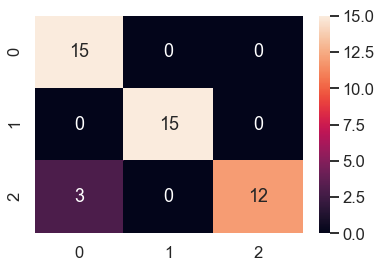

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

## Question 11

* Create an AdaBoost model and fit it using grid search, much like question 10. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {'n_estimators':[100,150, 200],
              'learning_rate':[0.1,0.01]}

gv_abc = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_features=4)),
                     param_grid=param_grid,
                     scoring='accuracy',
                     n_jobs=-1)
gv_abc = gv_abc.fit(X_train, y_train)


C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best model.

In [42]:
# The best model
gv_abc.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=200, random_state=None)

The error metrics. Note that the issues with class 0,1 and 2 appear to have become more problematic and now include class 0. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [43]:
y_pred = gv_abc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      1.00      1.00        15
           2       1.00      0.73      0.85        15

   micro avg       0.91      0.91      0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



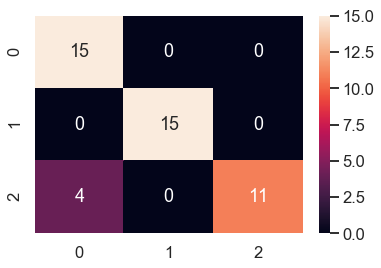

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

## Question 12

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 10 and 11.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [ ]:
y_pred = lr_l2.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [('lr_l2',lr_l2),('gv_gbc',gv_gbc)]
vc = VotingClassifier(estimators,voting='soft')
vc.fit(X_train, y_train)

Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [ ]:
y_pred = vc.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')